In [25]:
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank, MassBasedTank
from math import exp
from datetime import datetime, timedelta
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt

Fetching elevation from open-elevation.com for lat=35.35, lon=-117.81...
Elevation received: 621.0 m


c:\Users\krikb\Desktop\Pulpit\agh_space_systems\simulations\.venv\Lib\site-packages\rocketpy\environment\tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2026-02-13 12:00:00 UTC instead.
  warnings.warn(


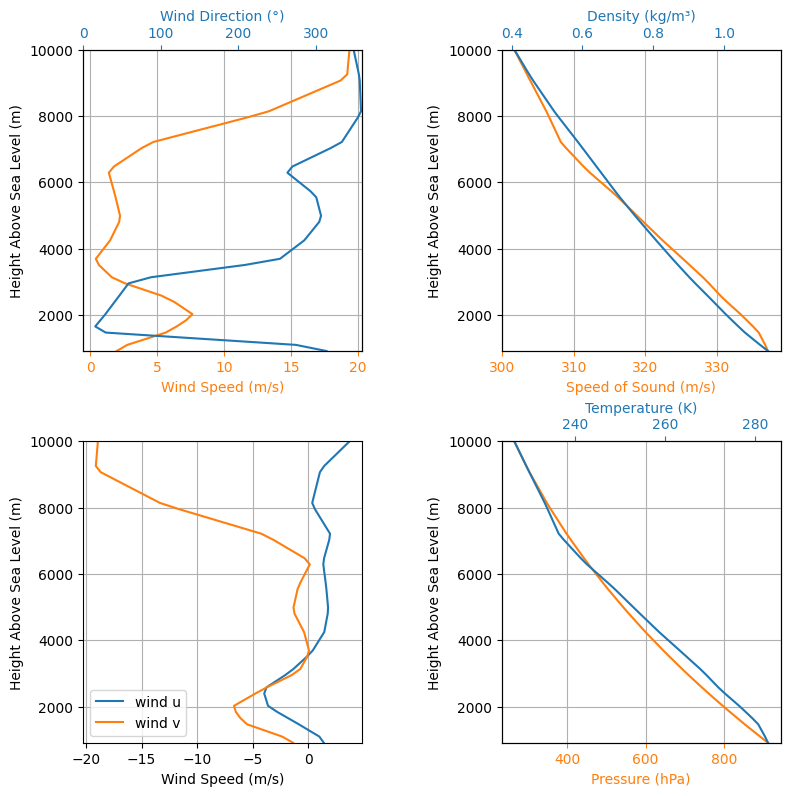


Gravity Details

Acceleration of gravity at surface level:    9.7948 m/s²
Acceleration of gravity at  10.000 km (ASL): 9.7668 m/s²


Launch Site Details

Launch Date: 2026-02-13 13:01:59 UTC
Launch Site Latitude: 35.35000°
Launch Site Longitude: -117.81000°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 426401.45 W    3912158.86 N
Launch Site UTM zone: 11S
Launch Site Surface Elevation: 907.8 m


Atmospheric Model Details

Atmospheric Model Type: forecast
forecast Maximum Height: 10.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 1.97 m/s
Surface Wind Direction: 313.96°
Surface Wind Heading: 133.96°
Surface Pressure: 912.44 hPa
Surface Temperature: 282.89 K
Surface Air Density: 1.124 kg/m³
Surface Speed of Sound: 337.17 m/s


Earth Model Details

Earth Radius at Launch site: 6371.02 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



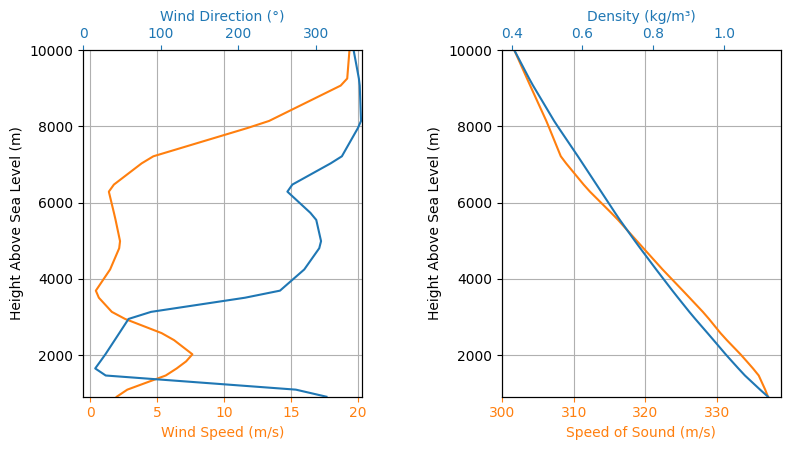

In [26]:
#Far-out
tomorrow = datetime.now() + timedelta(days=1)
env = Environment(
    date=tomorrow,  
    latitude=35.35,
    longitude=-117.81, # Far-out not precise
)
env.set_elevation("Open-Elevation")
env.set_atmospheric_model(type="forecast", file="GFS")
env.max_expected_height = 10000
env.plots.atmospheric_model()

env.info()

In [27]:
# Stałe dla turbulencji
external_tank_diameter = 0.2
tank_height = 1.13
thickness_tank = 0.005
thickness_piston = 0.01

# Parametry, które potrzebuję
p_0 = 63e5 #ciśnienie początkowe
piston_position = 0.85
total_oxidizer_mass = 18
flux_time = 11.2 # the start time will be useful as well
# csv z masą utleniacza i paliwa w czasie
ethanol_temperature = 300
# Parametry, które zakładem
gas_initial_mass_fuel = 0

# Parametry, które wyliczam
N20_liq_density = PropsSI("D", "P", p_0, "Q", 0, "NitrousOxide")
N20_gas_density = PropsSI("D", "P", p_0, "Q", 1, "NitrousOxide")
ethanol_liq_density = PropsSI("D", "P", p_0-1e5, "T", ethanol_temperature, "Ethanol") # PropSI pokazuje 63e5 powyżej krytycznego, dlatego odejmuję
ethanol_gas_density = PropsSI("D", "P", p_0-1e5, "Q", 1, "Ethanol")

volume_tank = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*tank_height
volume_piston = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*thickness_piston
volume_oxidizer = piston_position*volume_tank
volume_fuel = volume_tank - volume_oxidizer - volume_piston

gas_initial_mass_ox = (volume_oxidizer - (total_oxidizer_mass / N20_liq_density)) / (1/N20_gas_density - 1/N20_liq_density)
liquid_initial_mass_ox = total_oxidizer_mass - gas_initial_mass_ox
liquid_initial_mass_fuel = volume_fuel * ethanol_liq_density

# Parametry stricte pod tank_geometry
tank_radius = (external_tank_diameter - 2*thickness_tank) / 2
adjusted_height_ox = piston_position*tank_height
adjusted_height_fuel = tank_height - adjusted_height_ox - thickness_piston

# Dla sprawdzenia czy wychodzi mi to samo co volume_oxidizer i volume_fuel
fuel_tank_volume = np.pi * tank_radius**2 * adjusted_height_fuel
oxidizer_tank_volume = np.pi * tank_radius**2 * adjusted_height_ox

In [28]:
# Defining fluids
print(f"N2O liquid density: {N20_liq_density} kg/m^3")
print(f"N2O gas density: {N20_gas_density} kg/m^3")
print(f"Ethanol liquid density: {ethanol_liq_density} kg/m^3")
print(f"Ethanol gas density: {ethanol_gas_density} kg/m^3")

oxidizer_liq = Fluid(name="N2O_l", density=N20_liq_density)
oxidizer_gas = Fluid(name="N2O_g", density=N20_gas_density)
fuel_liq = Fluid(name="ethanol_l", density=ethanol_liq_density) 
fuel_gas = Fluid(name="ethanol_g", density=ethanol_gas_density)

N2O liquid density: 688.8282624309604 kg/m^3
N2O gas density: 232.09456330326952 kg/m^3
Ethanol liquid density: 788.9744211607459 kg/m^3
Ethanol gas density: 230.0774192082292 kg/m^3


In [29]:
print(f"Total tank volume: {volume_tank} m^3")
print(f"Volume occupied by the piston: {volume_piston} m^3")
print(f"Volume of oxidizer: {volume_oxidizer} m^3")
print(f"Volume of fuel: {volume_fuel} m^3")
print(f"Initial mass of oxidizer gas: {gas_initial_mass_ox} kg")
print(f"Initial mass of oxidizer liquid: {liquid_initial_mass_ox} kg")
print(f"Fuel mass: {liquid_initial_mass_fuel} kg")
print(f"Adjusted height of oxidizer tank: {adjusted_height_ox} m")
print(f"Adjusted height of fuel tank: {adjusted_height_fuel} m")
print(f"Fuel tank volume: {fuel_tank_volume} m^3")
print(f"Oxidizer tank volume: {oxidizer_tank_volume} m^3")

Total tank volume: 0.032038747279472105 m^3
Volume occupied by the piston: 0.00028352873698647886 m^3
Volume of oxidizer: 0.027232935187551287 m^3
Volume of fuel: 0.004522283354934339 m^3
Initial mass of oxidizer gas: 0.3856009208279634 kg
Initial mass of oxidizer liquid: 17.61439907917204 kg
Fuel mass: 3.5679658922841964 kg
Adjusted height of oxidizer tank: 0.9604999999999999 m
Adjusted height of fuel tank: 0.15949999999999998 m
Fuel tank volume: 0.0045222833549343365 m^3
Oxidizer tank volume: 0.02723293518755129 m^3


In [30]:
# Tank geometry
oxidizer_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_ox,
)
fuel_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_fuel,
)

In [31]:
# Define tanks
mass_flow_rate_liq = round(liquid_initial_mass_ox/flux_time, 2) - 0.005 # waiting for csv
mass_flow_rate_gas = round(gas_initial_mass_ox/flux_time - 0.005, 2) # waiting for csv

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=(1, flux_time+1), 
    initial_liquid_mass=liquid_initial_mass_ox, 
    initial_gas_mass=gas_initial_mass_ox,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=mass_flow_rate_liq, 
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=mass_flow_rate_gas, 
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)


In [32]:
#mass based tank 
gas_mass_function_ox = oxidizer_tank.gas_mass
liq_mass_function_ox = oxidizer_tank.liquid_mass
mass_based_oxidizer_tank = MassBasedTank(
    name="mass based oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=(1, flux_time+1),
    gas=oxidizer_gas,
    liquid=oxidizer_liq,
    gas_mass=gas_mass_function_ox,
    liquid_mass=liq_mass_function_ox,
    discretize=100,
)



Tank 'oxidizer tank' Data:

Tank Geometry:
Average radius 0.095 m
Bottom: -0.48024999999999995 m
Top: 0.48024999999999995 m
Total height: 0.9604999999999999 m
Total volume: 0.027233 m^3

Tank 'oxidizer tank' Fluid Parameters:

Liquid Fluid
Name: N2O_l
Density: 688.8283 kg/m^3

Gas Fluid
Name: N2O_g
Density: 232.0946 kg/m^3

Tank 'oxidizer tank' Mass Flux Data:

Initial Quantities at t = 1.00 s:
Initial Fluid Mass: 1.800e+01 kg
Initial Liquid Volume: 2.557e-02 m^3
Initial Liquid Level: 4.217e-01 m

Final Quantities at t = 12.20 s:
Final Fluid Mass: 1.360e-01 kg
Final Liquid Volume: 1.254e-04 m^3
Final Liquid Level: -4.758e-01 m


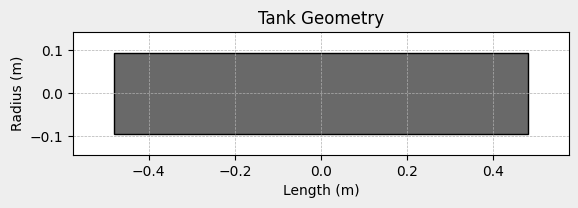

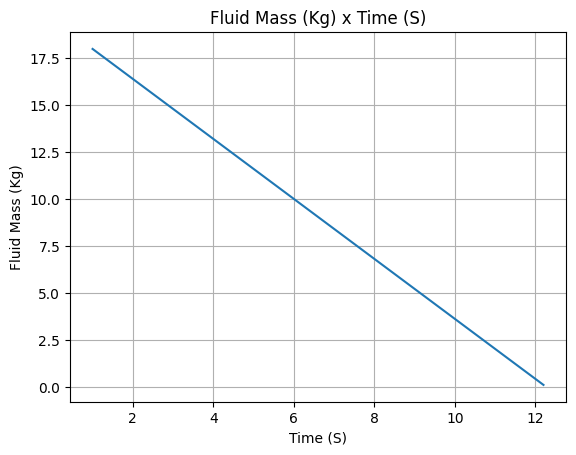

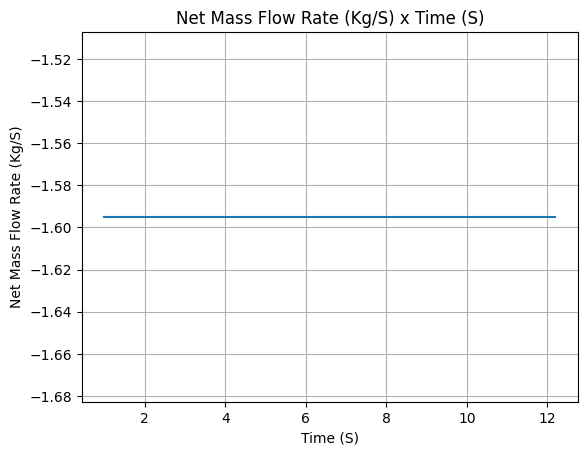

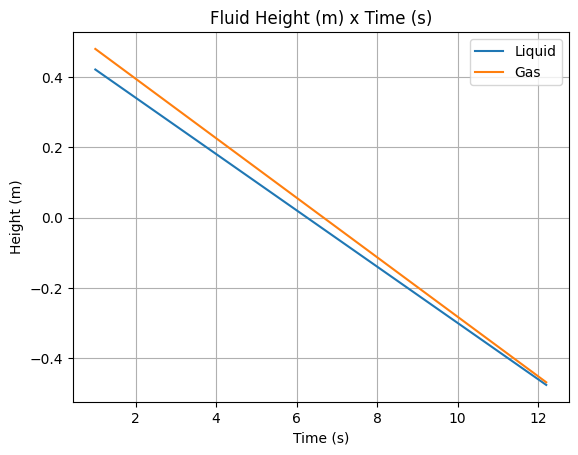

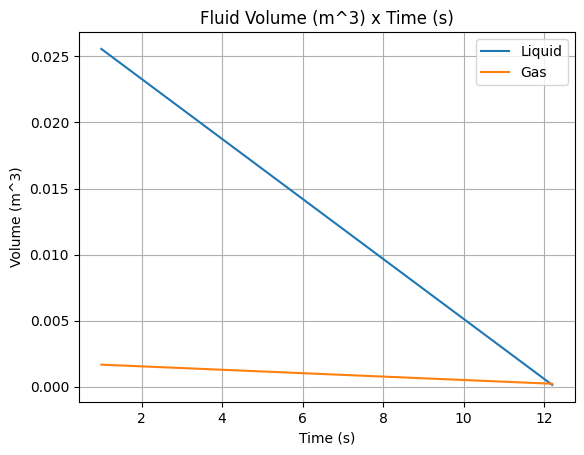

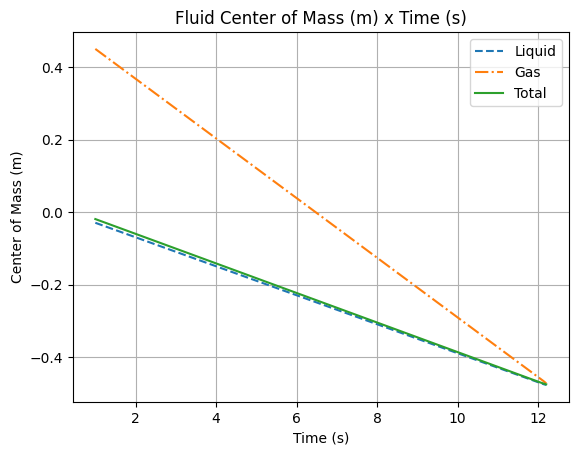

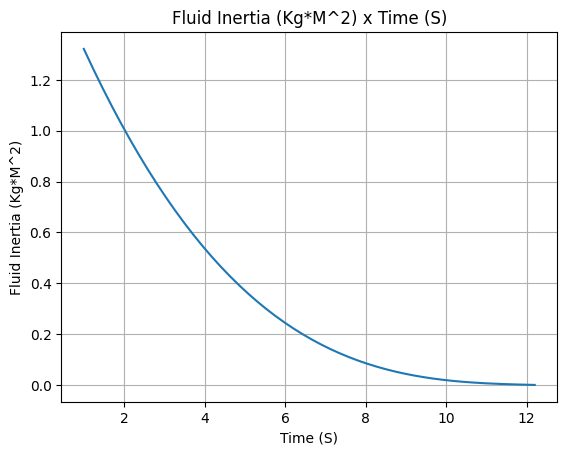


Tank 'mass based oxidizer tank' Data:

Tank Geometry:
Average radius 0.095 m
Bottom: -0.48024999999999995 m
Top: 0.48024999999999995 m
Total height: 0.9604999999999999 m
Total volume: 0.027233 m^3

Tank 'mass based oxidizer tank' Fluid Parameters:

Liquid Fluid
Name: N2O_l
Density: 688.8283 kg/m^3

Gas Fluid
Name: N2O_g
Density: 232.0946 kg/m^3

Tank 'mass based oxidizer tank' Mass Flux Data:

Initial Quantities at t = 1.00 s:
Initial Fluid Mass: 1.800e+01 kg
Initial Liquid Volume: 2.557e-02 m^3
Initial Liquid Level: 4.217e-01 m

Final Quantities at t = 12.20 s:
Final Fluid Mass: 1.360e-01 kg
Final Liquid Volume: 1.254e-04 m^3
Final Liquid Level: -4.758e-01 m


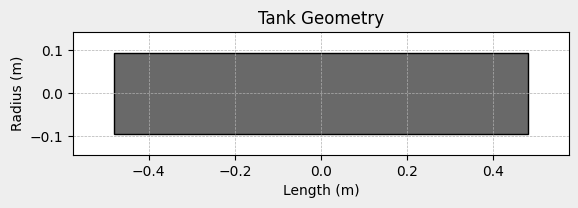

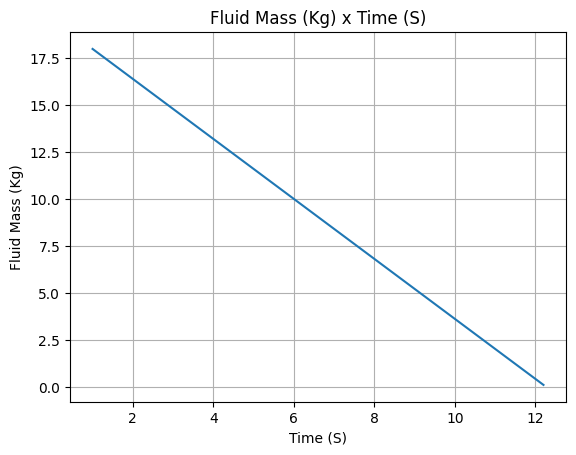

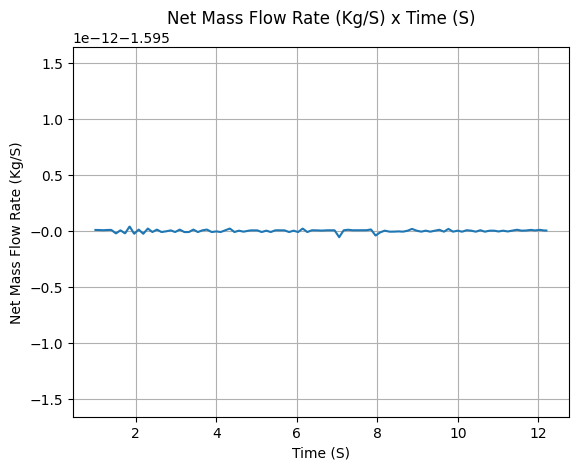

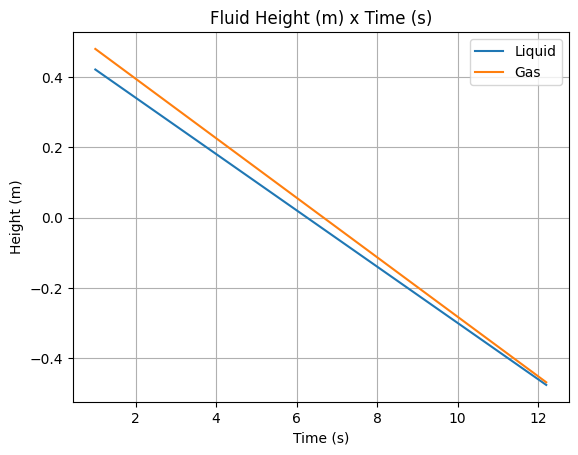

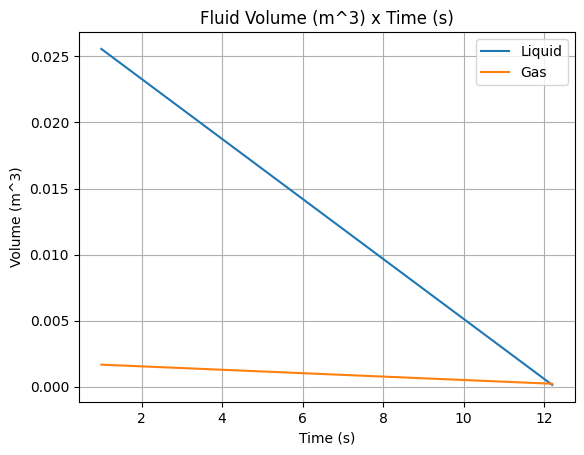

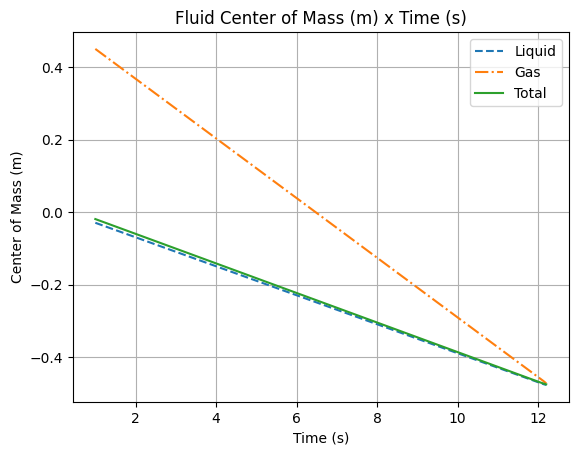

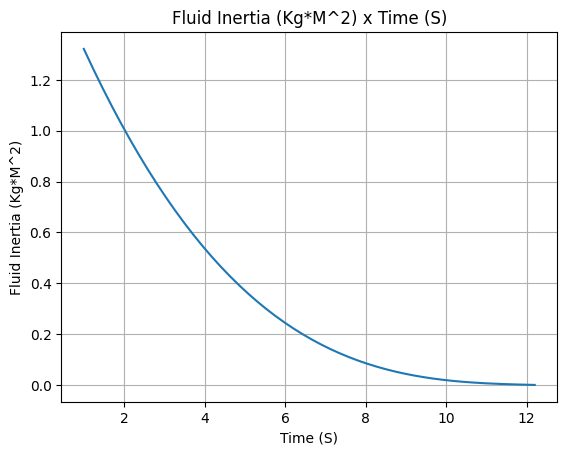

In [33]:
oxidizer_tank.all_info()
mass_based_oxidizer_tank.all_info()

In [34]:
#Fuel tank
fuel_mass_flow_rate = liquid_initial_mass_fuel / flux_time - 0.01
fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=(1, flux_time+1),
    initial_liquid_mass=liquid_initial_mass_fuel-0.00001, #Same as above, only guess
    initial_gas_mass=gas_initial_mass_fuel,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=fuel_mass_flow_rate, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

In [35]:
#mass based tank
gas_mass_function_fuel = fuel_tank.gas_mass
liq_mass_function_fuel = fuel_tank.liquid_mass
mass_based_fuel_tank = MassBasedTank(
    name="mass based fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=(1, flux_time+1),
    gas=fuel_gas,
    liquid=fuel_liq,
    gas_mass=gas_mass_function_fuel,
    liquid_mass=liq_mass_function_fuel,
    discretize=100,
)


Tank 'fuel tank' Data:

Tank Geometry:
Average radius 0.095 m
Bottom: -0.07974999999999999 m
Top: 0.07974999999999999 m
Total height: 0.15949999999999998 m
Total volume: 0.004522 m^3

Tank 'fuel tank' Fluid Parameters:

Liquid Fluid
Name: ethanol_l
Density: 788.9744 kg/m^3

Gas Fluid
Name: ethanol_g
Density: 230.0774 kg/m^3

Tank 'fuel tank' Mass Flux Data:

Initial Quantities at t = 1.00 s:
Initial Fluid Mass: 3.568e+00 kg
Initial Liquid Volume: 4.522e-03 m^3
Initial Liquid Level: 7.975e-02 m

Final Quantities at t = 12.20 s:
Final Fluid Mass: 1.120e-01 kg
Final Liquid Volume: 1.419e-04 m^3
Final Liquid Level: -7.474e-02 m


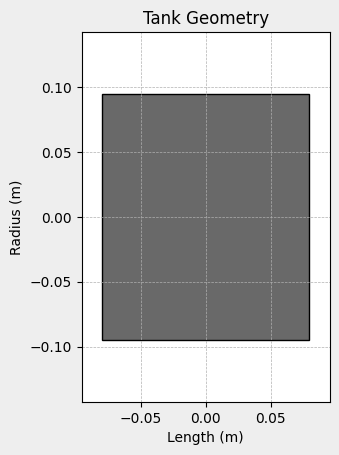

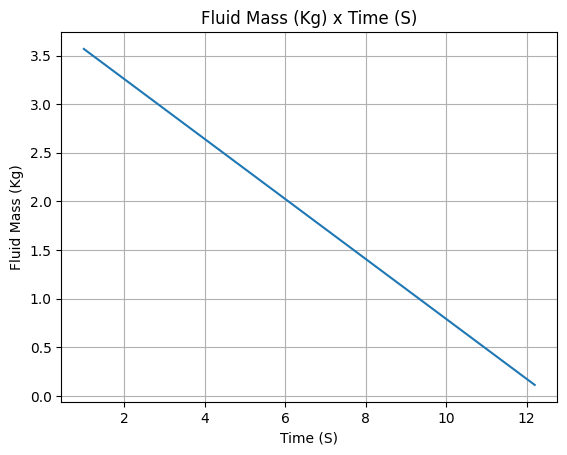

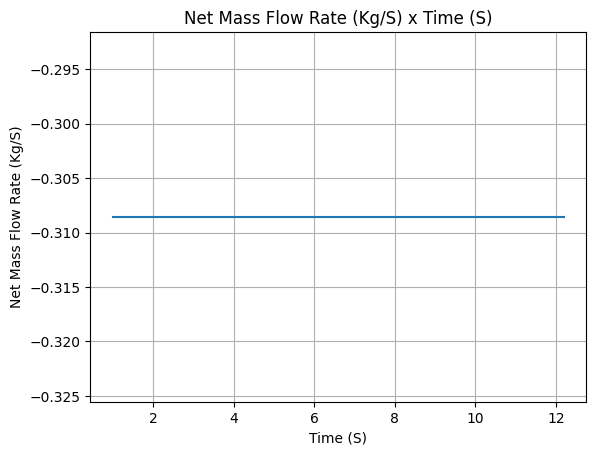

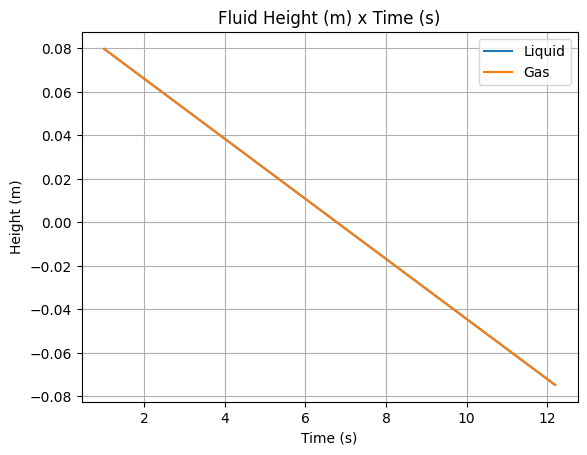

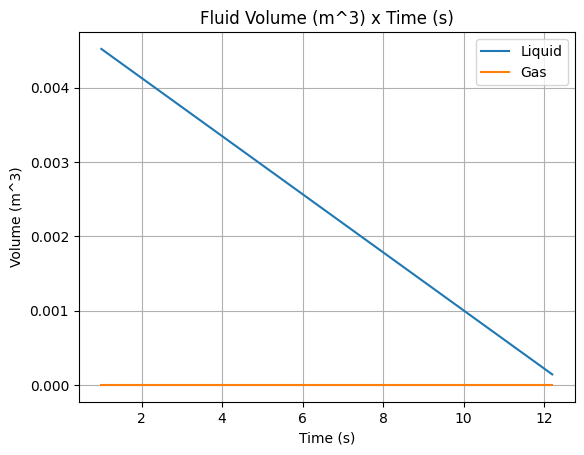

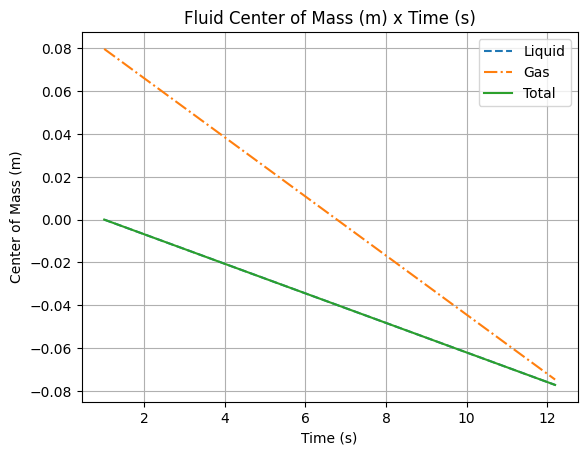

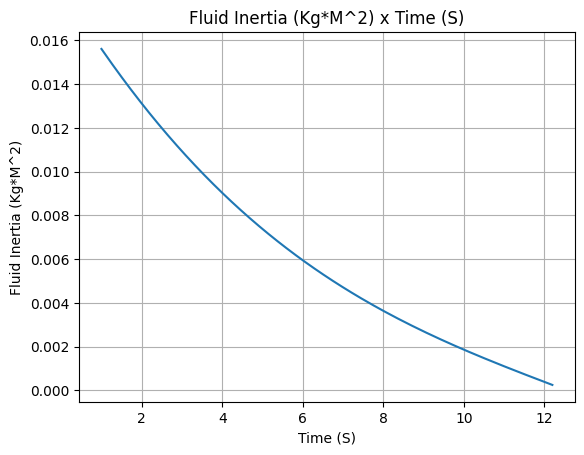


Tank 'mass based fuel tank' Data:

Tank Geometry:
Average radius 0.095 m
Bottom: -0.07974999999999999 m
Top: 0.07974999999999999 m
Total height: 0.15949999999999998 m
Total volume: 0.004522 m^3

Tank 'mass based fuel tank' Fluid Parameters:

Liquid Fluid
Name: ethanol_l
Density: 788.9744 kg/m^3

Gas Fluid
Name: ethanol_g
Density: 230.0774 kg/m^3

Tank 'mass based fuel tank' Mass Flux Data:

Initial Quantities at t = 1.00 s:
Initial Fluid Mass: 3.568e+00 kg
Initial Liquid Volume: 4.522e-03 m^3
Initial Liquid Level: 7.975e-02 m

Final Quantities at t = 12.20 s:
Final Fluid Mass: 1.120e-01 kg
Final Liquid Volume: 1.419e-04 m^3
Final Liquid Level: -7.474e-02 m


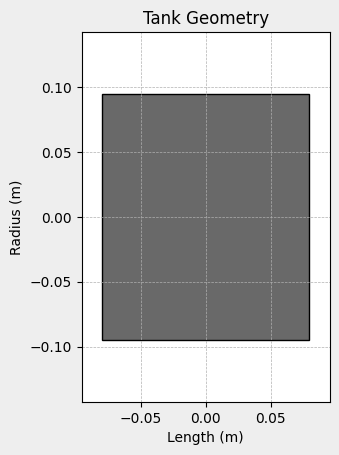

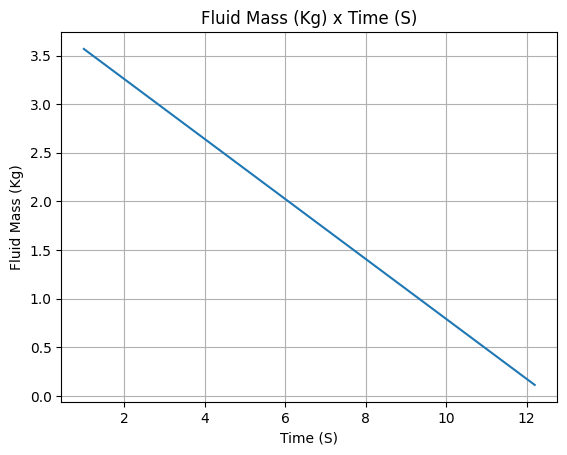

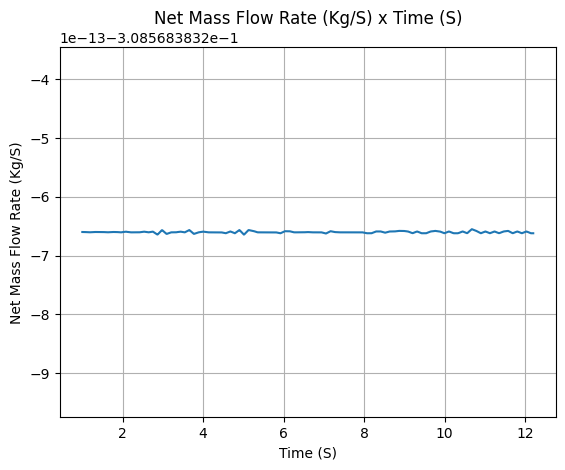

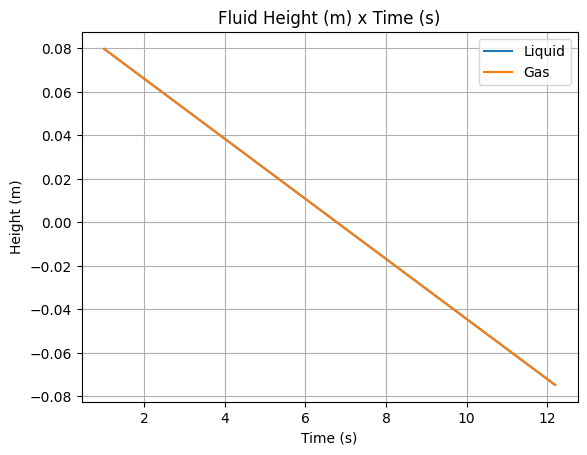

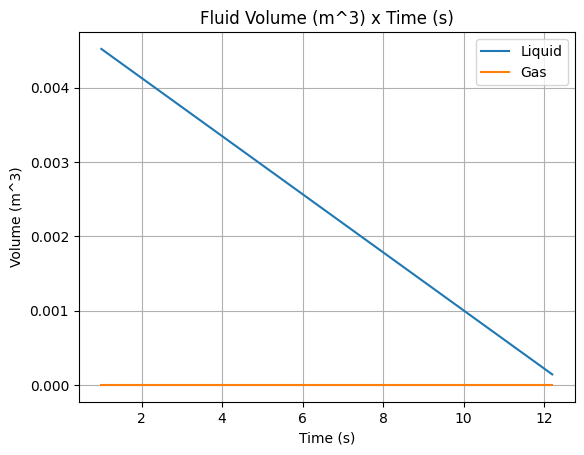

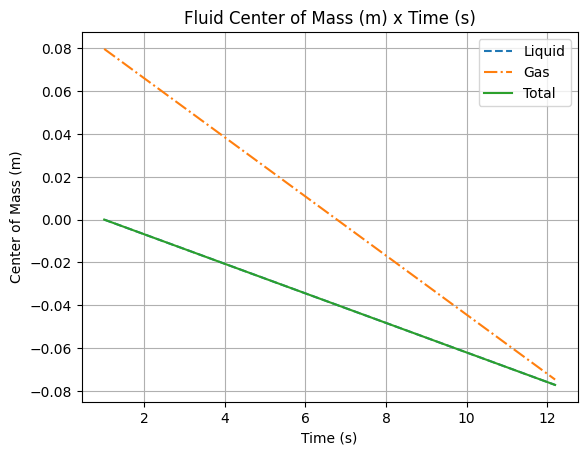

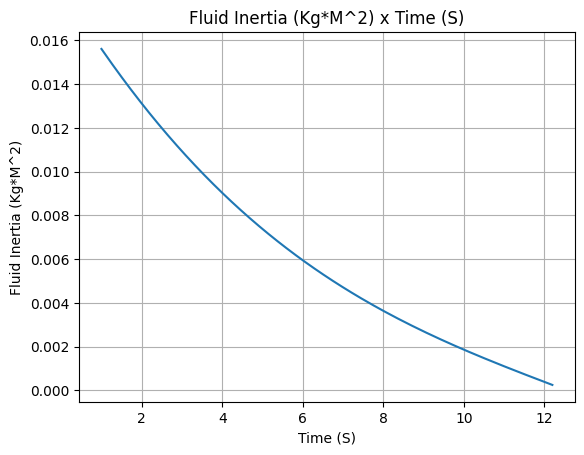

In [36]:
fuel_tank.all_info()
mass_based_fuel_tank.all_info()

Nozzle Details
Nozzle Radius: 0.036 m

Motor Details
Total Burning Time: 14.4 s
Total Propellant Mass: 21.568 kg
Structural Mass Ratio: 0.111
Average Propellant Exhaust Velocity: 1036.192 m/s
Average Thrust: 2240.935 N
Maximum Thrust: 4575.401 N at 1.089 s after ignition.
Total Impulse: 32269.462 Ns



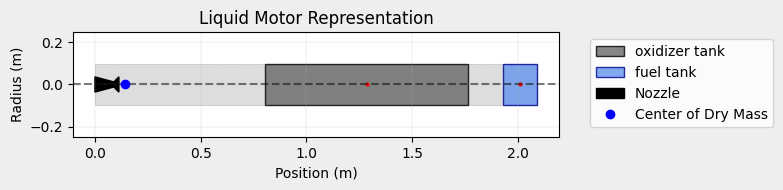

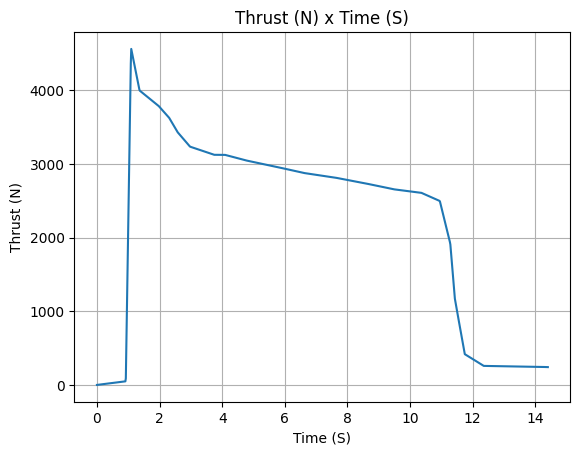

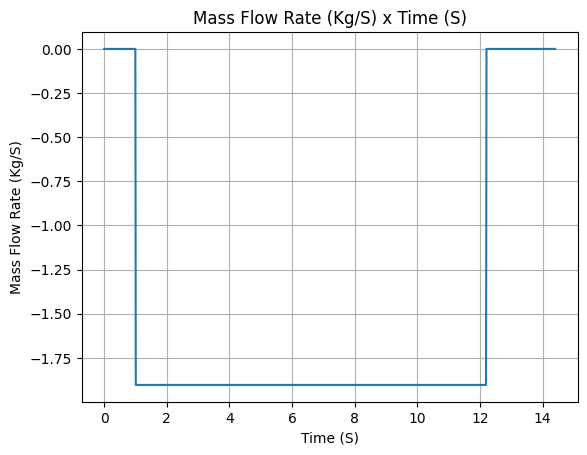

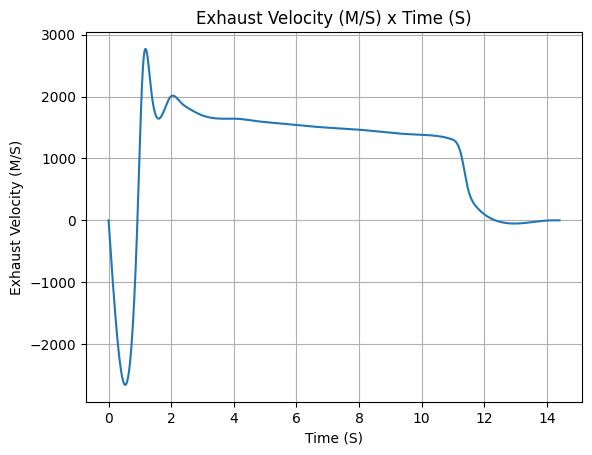

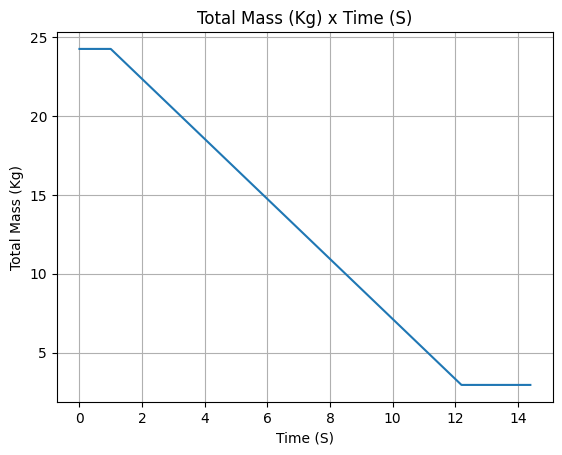

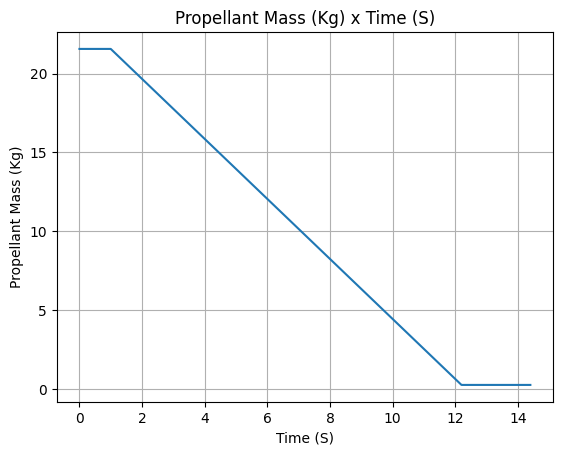

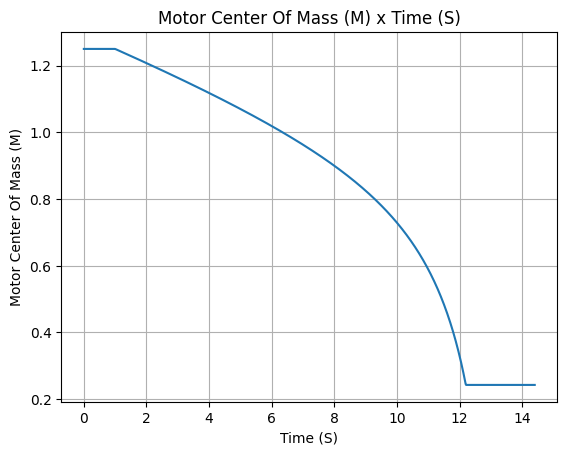

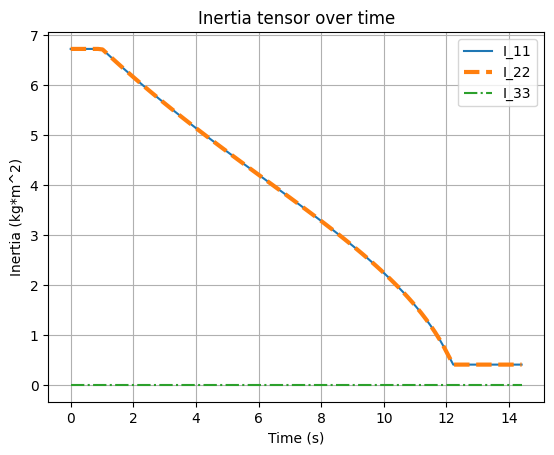

In [37]:
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)
z4000.all_info()


Inertia Details

Rocket Mass: 58.367 kg (without motor)
Rocket Dry Mass: 61.067 kg (with unloaded motor)
Rocket Loaded Mass: 82.635 kg
Rocket Structural Mass Ratio: 0.739
Rocket Inertia (with unloaded motor) 11: 82.097 kg*m2
Rocket Inertia (with unloaded motor) 22: 82.097 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.436 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.071 m
Rocket Center of Dry Mass - Nozzle Exit: 1.669 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.280 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.073 m


Aerodynamics Lift Coefficient Derivatives


Center of Pressure


Stability

Center of Mass position (time=0): 2.894 m
Center of Pressure position (time=0): 0.000

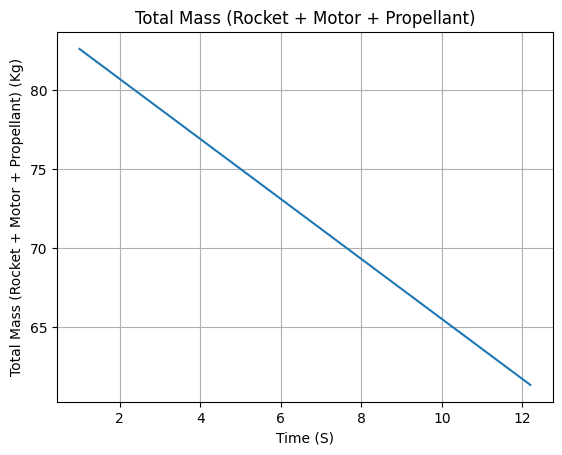

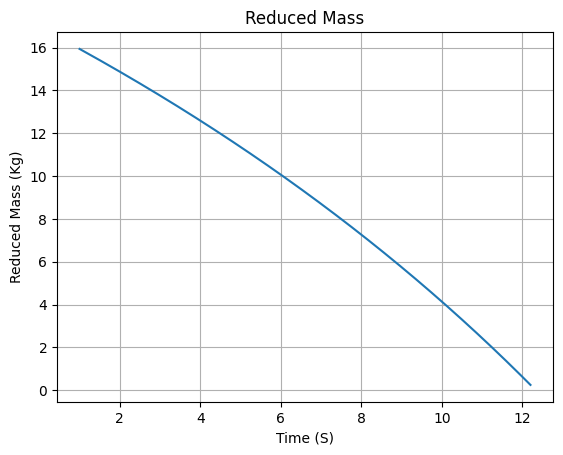


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


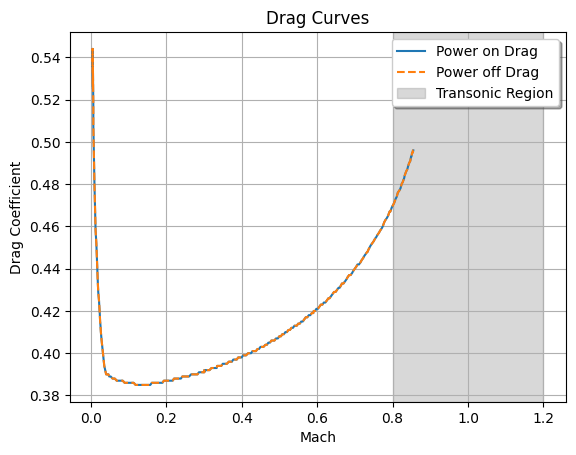


Stability Plots
--------------------


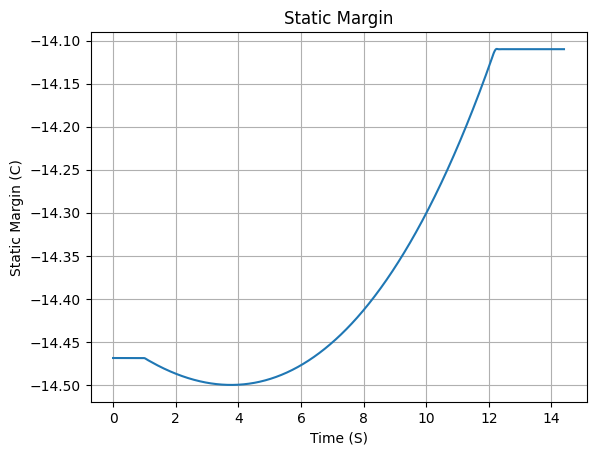

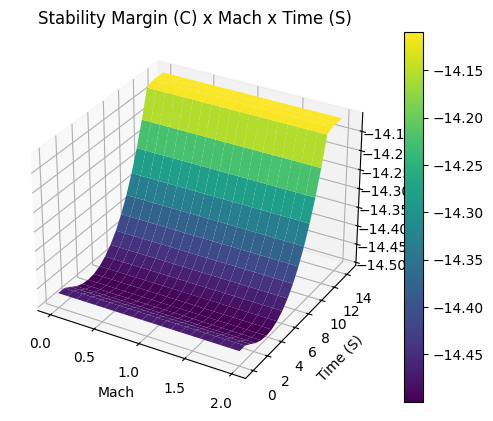


Thrust-to-Weight Plot
----------------------------------------


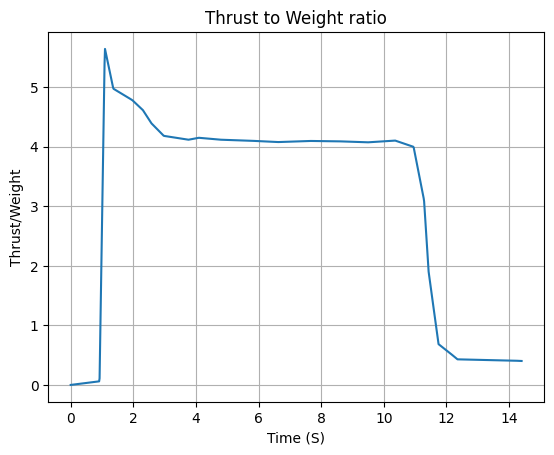

In [38]:
trb = Rocket(
    radius=0.1,
    mass=58.367, 
    inertia=(75.502, 75.502, 0.43), 
    power_off_drag=".\\data\\powerondrag.csv",  
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, 
    coordinate_system_orientation="nose_to_tail", 
)
trb.add_motor(z4000, position=4.49)
trb.all_info()

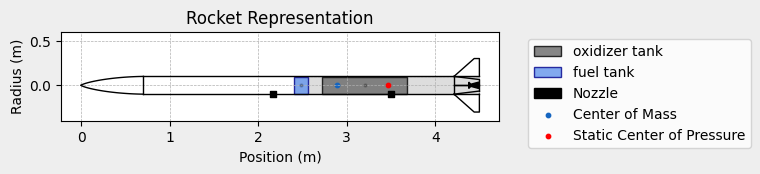

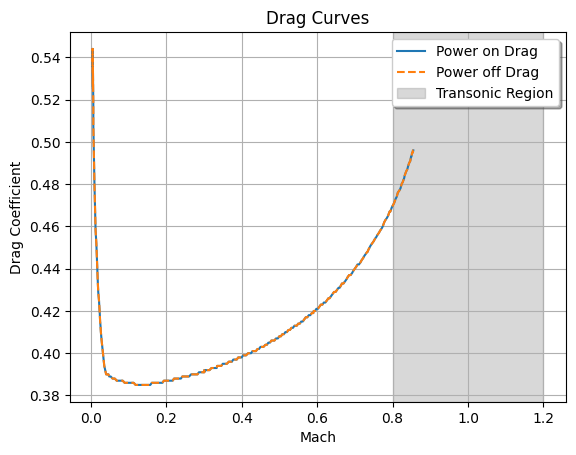

In [39]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2.17, #Just some value, not accurate
    lower_button_position=3.5, #Just some value, not accurate
    angular_position=0, #Just some value, not accurate #0 stopni
)

main = trb.add_parachute(
    name="main",
    cd_s=12.72, # cd * parachute area
    trigger=1000,      
    sampling_rate=105,
    lag=6,
    noise=(0, 8.3, 0.5),
    radius=2.25, 
    height=2.25,
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=1.218,
    trigger="apogee", 
    sampling_rate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
    radius=0.76,
    height=0.76,
    porosity=0.0432,
)

trb.draw()
trb.plots.drag_curves()


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 907.85 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: -0.999 | e1: 0.044 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : 360.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.871 c


Surface Wind Conditions

Frontal Surface Wind Speed: -1.38 m/s
Lateral Surface Wind Speed: -1.38 m/s


Launch Rail

Launch Rail Length: 15.24 m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 1.804 s
Rail Departure Velocity: 31.675 m/s
Rail Departure Stability Margin: 2.863 c
Rail Departure Angle of Attack: 3.554°
Rail Departure Thrust-Weight Ratio: 4.834
Rail Departure Reynolds Number: 4.054e+05


Burn out State

Burn out time: 14.400 s
Altitude at burn out: 3338.374 m (ASL) | 2430.526 m (AGL)
Rocket speed at burn out: 252.720 m/s
Freestream 

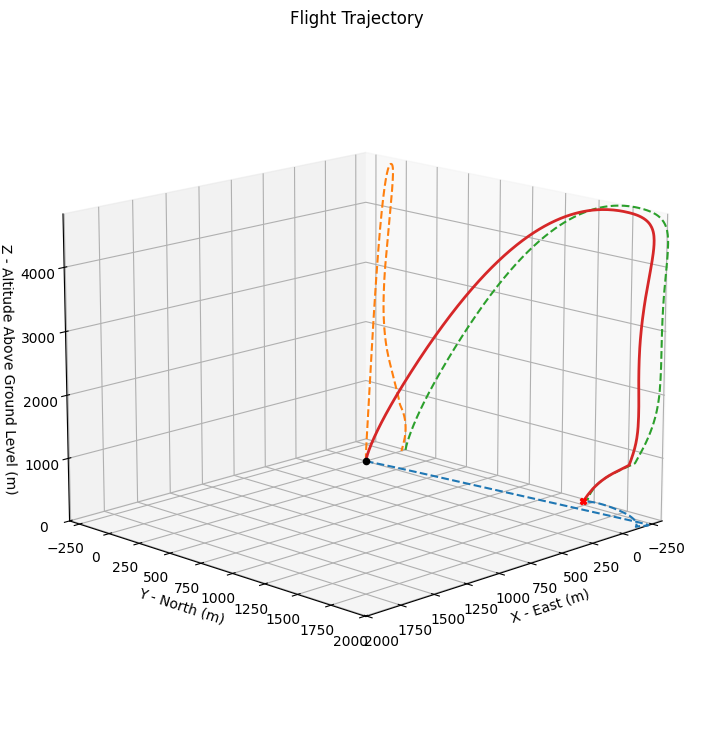



Trajectory Kinematic Plots



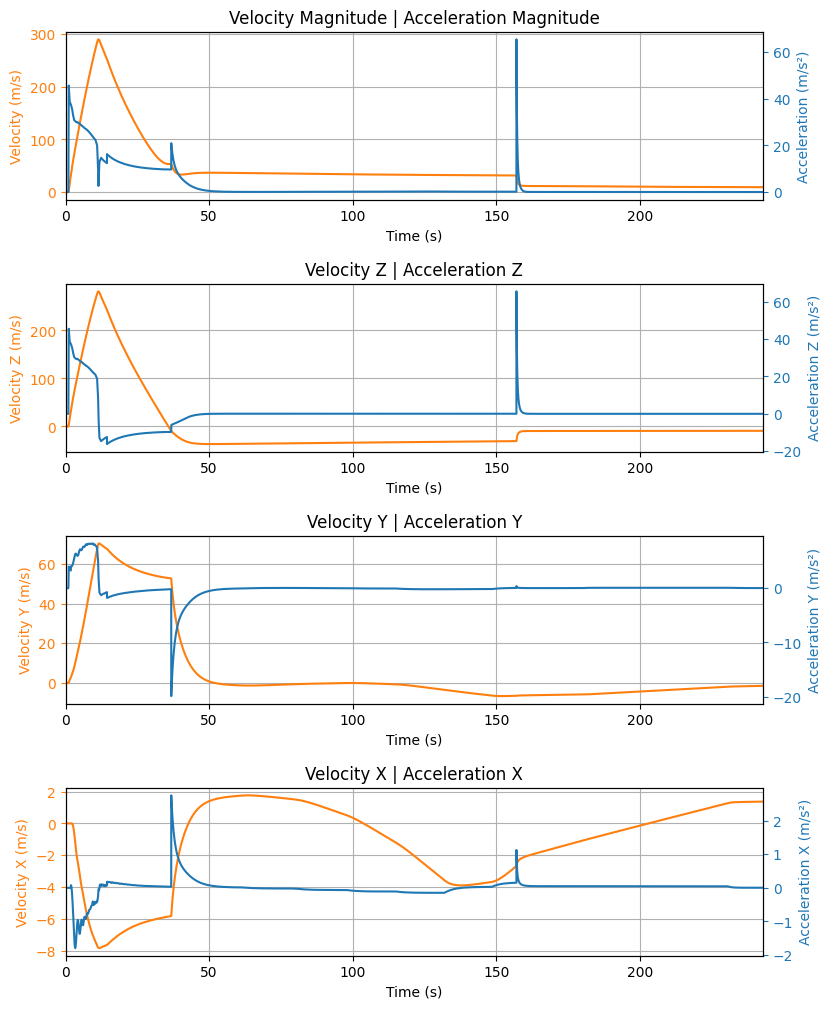



Angular Position Plots



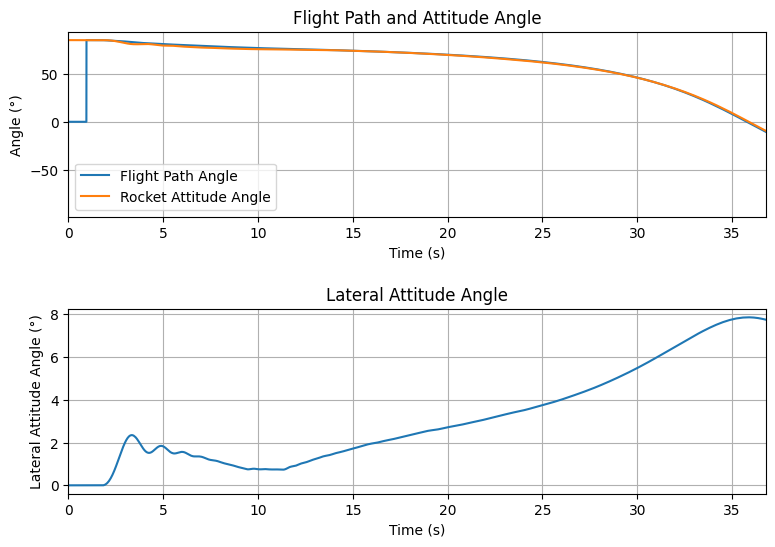



Path, Attitude and Lateral Attitude Angle plots



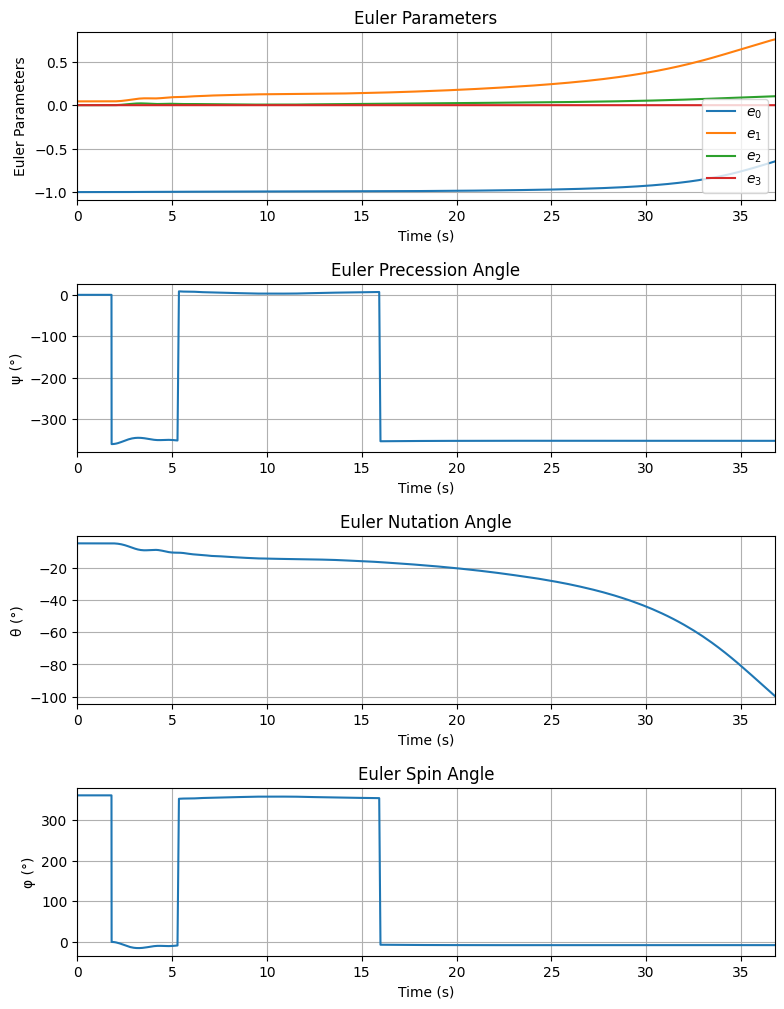



Trajectory Angular Velocity and Acceleration Plots



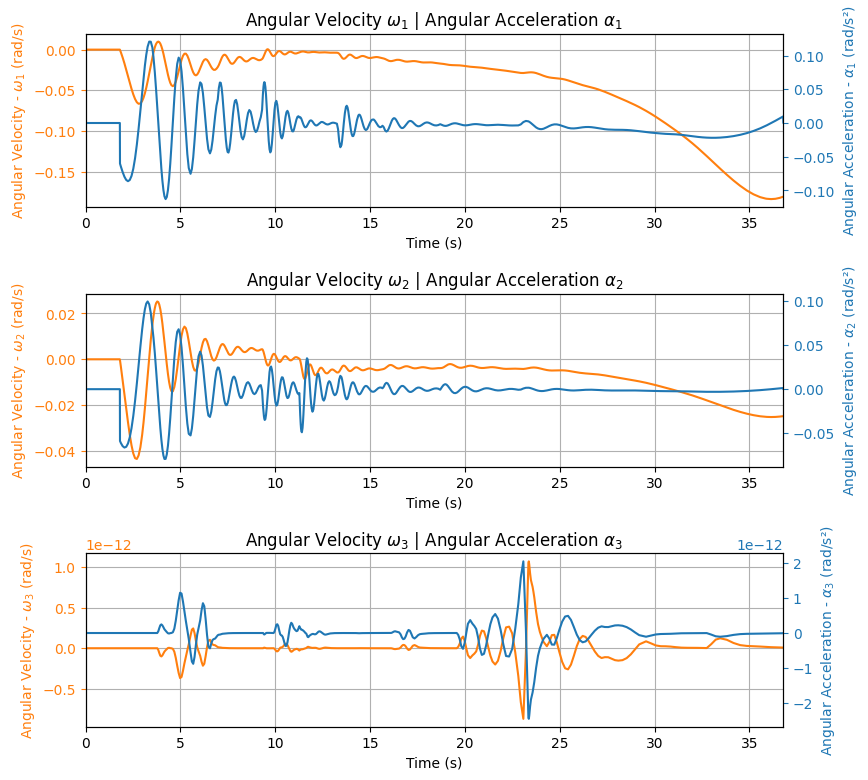



Aerodynamic Forces Plots



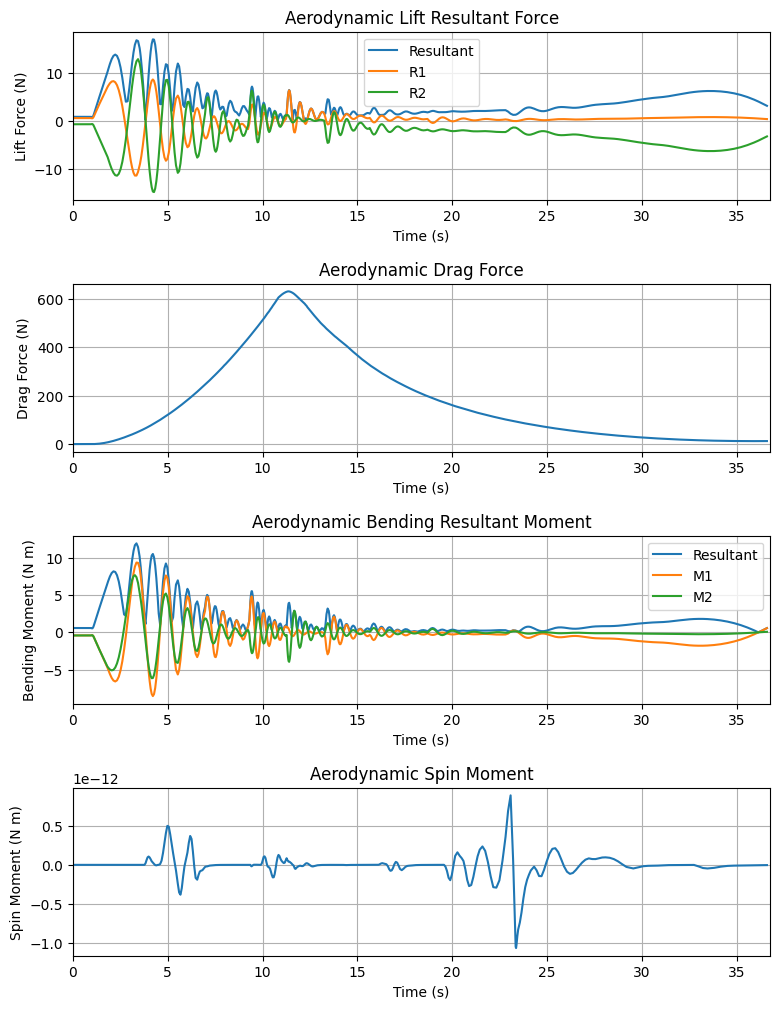



Rail Buttons Forces Plots



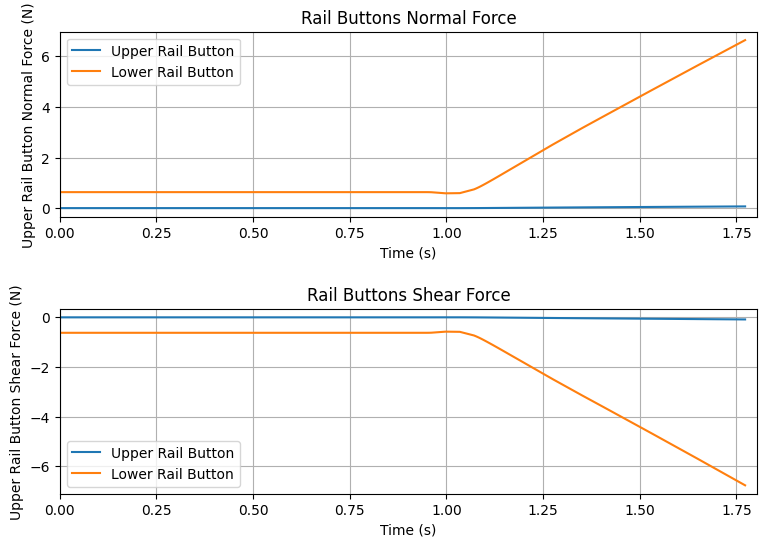



Trajectory Energy Plots



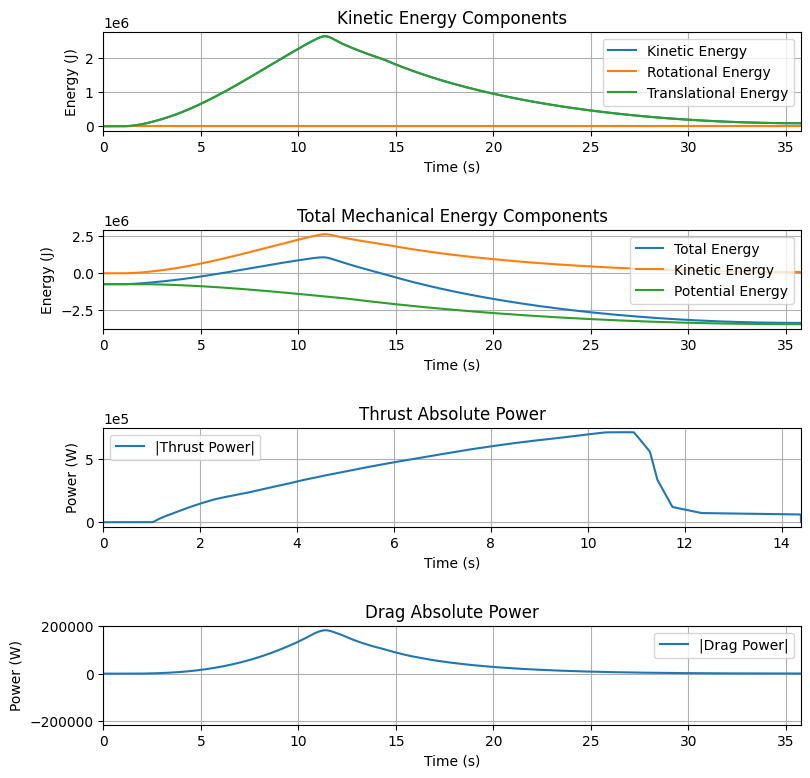



Trajectory Fluid Mechanics Plots



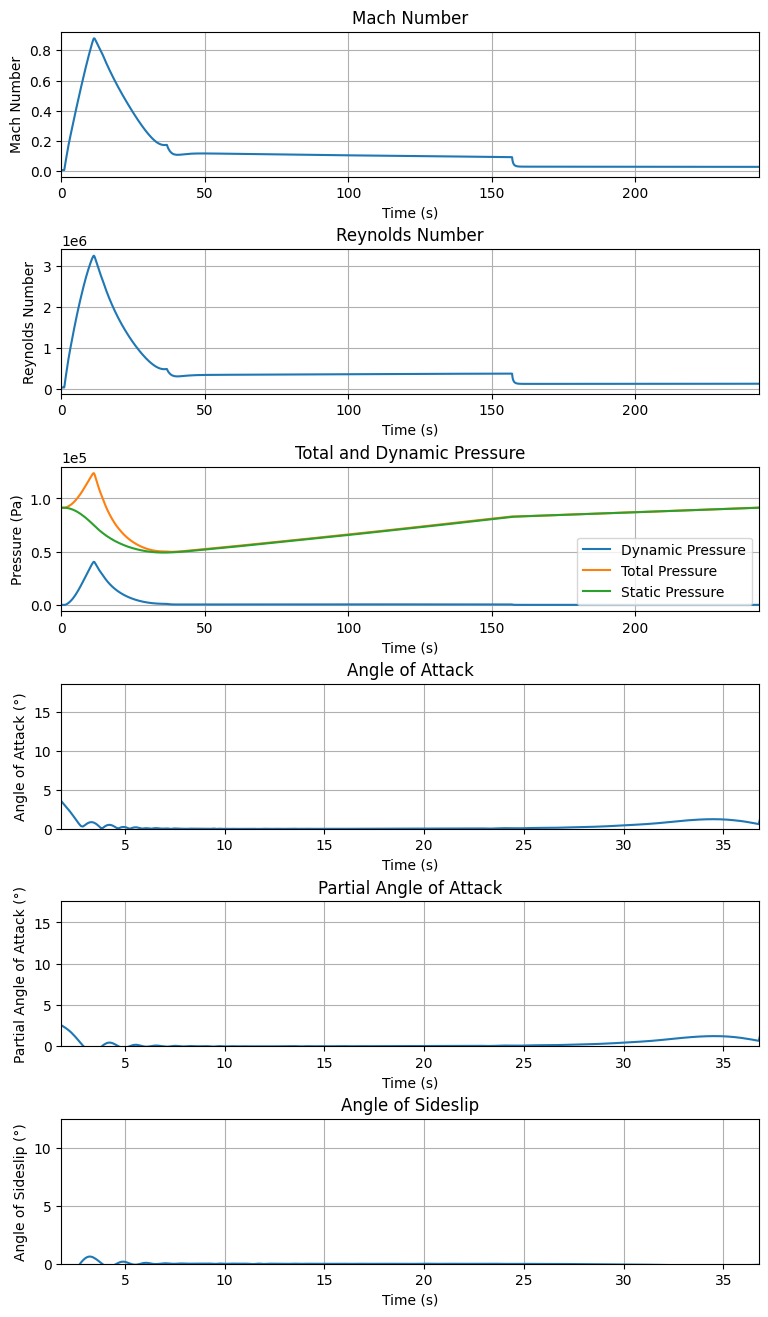



Trajectory Stability and Control Plots



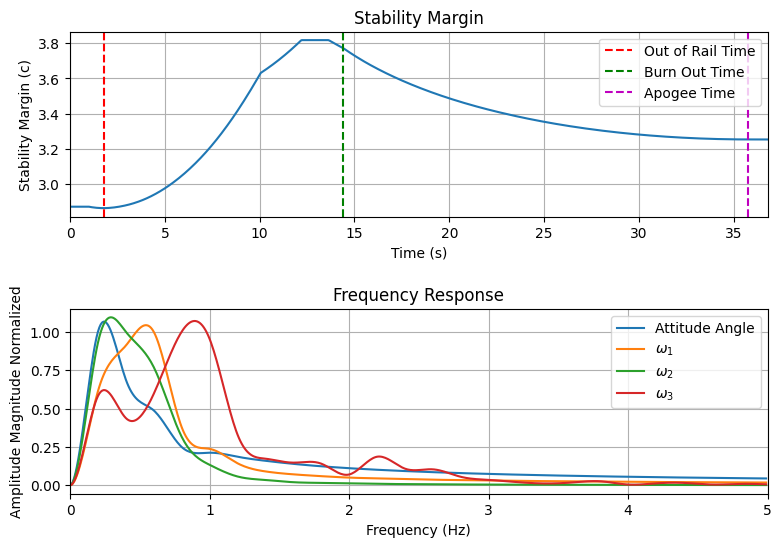



Rocket and Parachute Pressure Plots



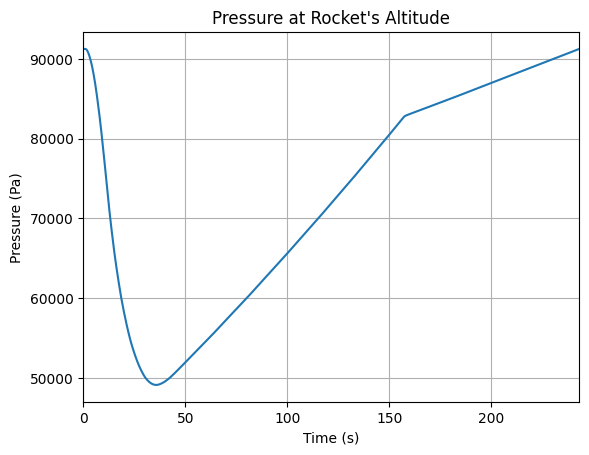


Parachute:  main


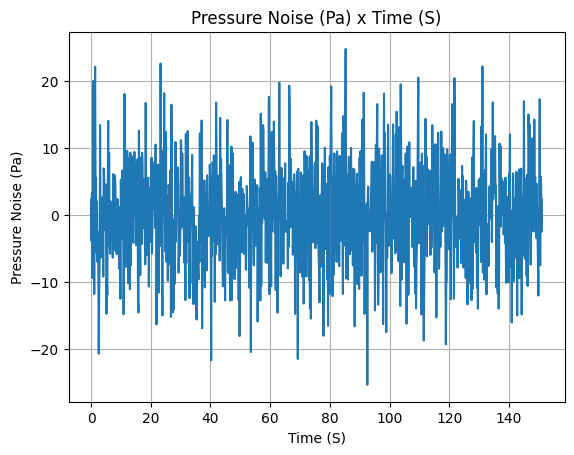

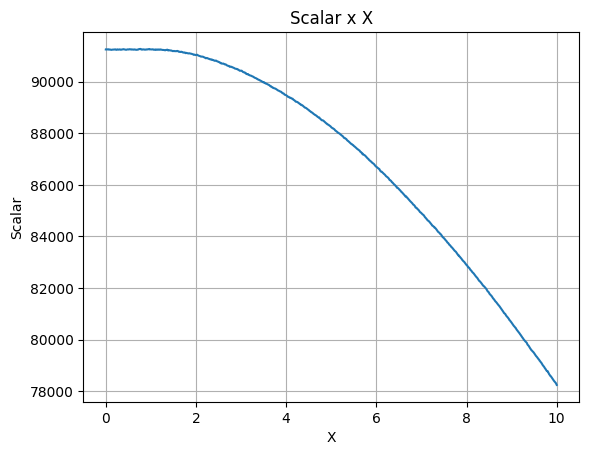

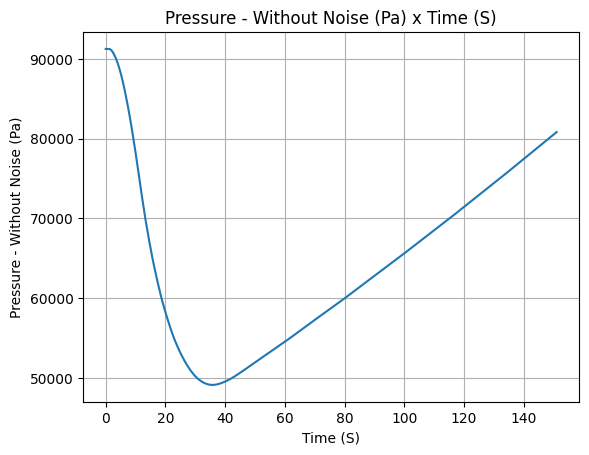


Parachute:  drogue


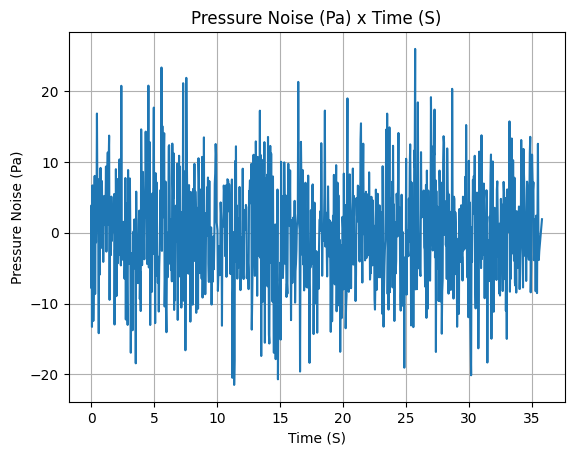

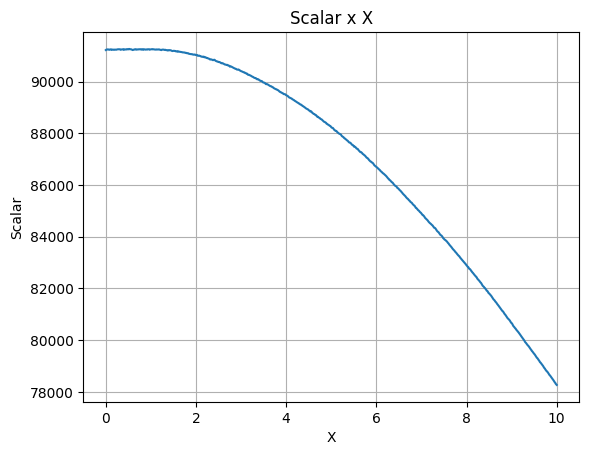

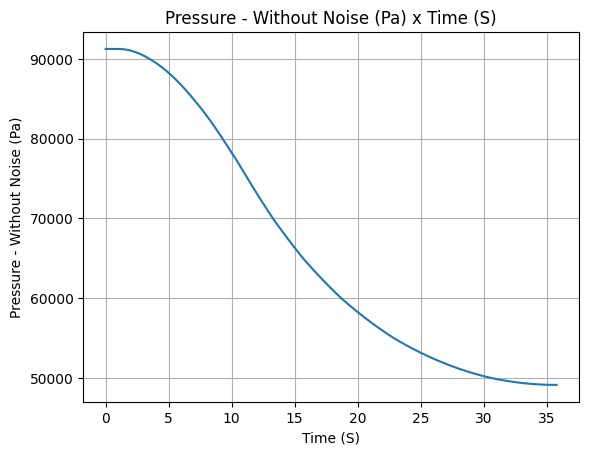

In [40]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=15.24, inclination=85, heading=0
    )

#trb.all_info()
test_flight.all_info()
#test_flight.plots.trajectory_3d()


In [41]:
#Rail Departure Velocity

# 1. Get SI Value from RocketPy
v_m_s = test_flight.out_of_rail_velocity

# 2. Convert to Imperial (ft/s)
v_ft_s = v_m_s * 3.28084

# 3. Get the exact time of rail exit
t_exit = test_flight.out_of_rail_time

print(f"Rail Departure Velocity (SI): {v_m_s:.2f} m/s")
print(f"Rail Departure Velocity (Imp): {v_ft_s:.2f} ft/s")
print(f"Time of Rail Exit: {t_exit:.3f} s")

Rail Departure Velocity (SI): 31.67 m/s
Rail Departure Velocity (Imp): 103.92 ft/s
Time of Rail Exit: 1.804 s


In [42]:
#Average TWR Calculation (Rail Phase)

t_exit = test_flight.out_of_rail_time 
g = 9.80665  # SI gravity 

#  100 sample points between 0 and t_exit 
rail_times = np.linspace(1, t_exit, 100)

# 3. Calculate Average Thrust 
thrust_values = [z4000.thrust(t) for t in rail_times]
avg_thrust = np.mean(thrust_values)

# 4. Calculate Average Mass during rail phase
propellant_mass_values = [z4000.propellant_mass(t) for t in rail_times]
total_mass_values = [trb.mass + z4000.propellant_mass(t) for t in rail_times]
avg_propellant_mass = np.mean(propellant_mass_values)
avg_total_mass = trb.mass + avg_propellant_mass # trb.mass is dry mass

# 5. Calculate TWR
twr_rail_avg = avg_thrust / (avg_total_mass * g)

# --- OUTPUT ---
print(f"Time on Rail: {t_exit:.4f} s")
print(f"Average Thrust (Rail Phase): {avg_thrust:.2f} N")
print(f"Average Total Mass (Rail Phase): {avg_total_mass:.2f} kg")
print(f"---------------------------------------------------")
print(f"TWR (Rail Phase Average): {twr_rail_avg:.4f}")

Time on Rail: 1.8038 s
Average Thrust (Rail Phase): 3974.61 N
Average Total Mass (Rail Phase): 79.17 kg
---------------------------------------------------
TWR (Rail Phase Average): 5.1193


In [43]:
test_flight.prints.stability_margin()


Stability Margin

Initial Stability Margin: 2.871 c at 0.00 s
Out of Rail Stability Margin: 2.863 c at 1.80 s
Maximum Stability Margin: 3.818 c at 12.23 s
Minimum Stability Margin: 2.863 c at 1.77 s


=== Damping Ratio Results ===
Lowest Damping Ratio:  0.0804 at t=3.35 s
Highest Damping Ratio: 0.1169 at t=4.22 s
✅ PASS: Minimum damping > 0.05.


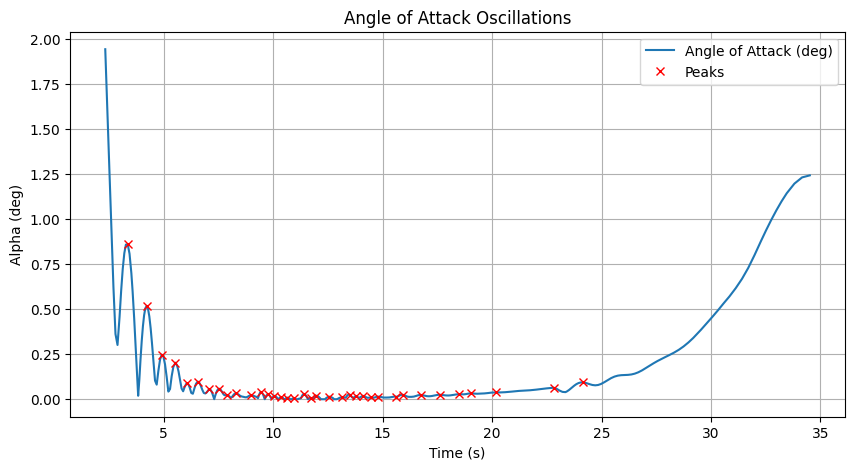

In [44]:

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# 1. Get Angle of Attack Data
# Fix: Extract only the 2nd column (values) if the array is 2D
raw_alpha = np.array(test_flight.angle_of_attack)
if raw_alpha.ndim > 1:
    alpha_values = raw_alpha[:, 1]  # Column 1 is Angle, Column 0 is Time
    time_values = raw_alpha[:, 0]
else:
    alpha_values = raw_alpha
    time_values = np.array(test_flight.time)

# 2. Filter for Ascent Phase (Rail Exit -> Apogee)
t_exit = test_flight.out_of_rail_time
t_apogee = test_flight.apogee_time
mask = (time_values > t_exit + 0.5) & (time_values < t_apogee - 1.0) # Buffer to avoid noise

t_data = time_values[mask]
alpha_data = alpha_values[mask]

# 3. Find Peaks in the Oscillation (Local Maxima)
peaks, _ = find_peaks(alpha_data, distance=5) 
peak_times = t_data[peaks]
peak_values = alpha_data[peaks]

# 4. Calculate Damping Ratio (Zeta) using Logarithmic Decrement
damping_ratios = []
damping_times = []

for i in range(len(peak_values) - 1):
    A1 = peak_values[i]
    A2 = peak_values[i+1]
    
    # Only calculate if amplitude is decaying and significant
    if A1 > A2 and A1 > 0.5: 
        delta = np.log(A1 / A2)
        zeta = 1 / np.sqrt(1 + (2 * np.pi / delta)**2)
        damping_ratios.append(zeta)
        damping_times.append(peak_times[i])

# 5. Output Results for Table
if len(damping_ratios) == 0:
    print("No significant oscillations detected. Rocket is likely Overdamped (zeta > 1.0).")
else:
    min_zeta = np.min(damping_ratios)
    max_zeta = np.max(damping_ratios)
    t_min = damping_times[np.argmin(damping_ratios)]
    t_max = damping_times[np.argmax(damping_ratios)]

    print(f"=== Damping Ratio Results ===")
    print(f"Lowest Damping Ratio:  {min_zeta:.4f} at t={t_min:.2f} s")
    print(f"Highest Damping Ratio: {max_zeta:.4f} at t={t_max:.2f} s")
    
    # Validation
    if min_zeta < 0.05:
        print(f"⚠️  WARNING: Underdamped (< 0.05). Risk of instability.")
    else:
        print(f"✅ PASS: Minimum damping > 0.05.")

    # 6. Plot for Verification
    plt.figure(figsize=(10, 5))
    plt.plot(t_data, alpha_data, label='Angle of Attack (deg)')
    plt.plot(peak_times, peak_values, "x", color='red', label='Peaks')
    plt.xlabel("Time (s)")
    plt.ylabel("Alpha (deg)")
    plt.title("Angle of Attack Oscillations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# max acceleration, speed, number of mach, dynamic pressure
max_acceleration = test_flight.max_acceleration
max_speed = test_flight.max_speed
max_mach = test_flight.max_mach_number
max_dynamic_pressure = test_flight.max_dynamic_pressure
max_acceleration_time = test_flight.max_acceleration_time
max_speed_time = test_flight.max_speed_time
max_dynamic_pressure_time = test_flight.max_dynamic_pressure_time
altitude_at_max_pressure = test_flight.z(max_dynamic_pressure_time)
max_altitude = test_flight.apogee
max_altitude_time = test_flight.apogee_time
print(f"Maximum Acceleration: {max_acceleration:.2f} m/s^2")
print(f"Maximum Speed: {max_speed:.2f} m/s")
print(f"Maximum Mach Number: {max_mach:.2f}")
print(f"Maximum Dynamic Pressure: {max_dynamic_pressure:.2f} Pa")
print(f"Time of Maximum Acceleration: {max_acceleration_time:.2f} s")
print(f"Time of Maximum Speed: {max_speed_time:.2f} s")
print(f"Time of Maximum Dynamic Pressure: {max_dynamic_pressure_time:.2f} s")
print(f"Altitude at Maximum Dynamic Pressure: {altitude_at_max_pressure:.2f} m")
print(f"Maximum Altitude: {max_altitude:.2f} m")
print(f"Time of Maximum Altitude: {max_altitude_time:.2f} s")

Maximum Acceleration: 65.55 m/s^2
Maximum Speed: 290.10 m/s
Maximum Mach Number: 0.88
Maximum Dynamic Pressure: 40470.46 Pa
Time of Maximum Acceleration: 157.05 s
Time of Maximum Speed: 11.43 s
Time of Maximum Dynamic Pressure: 11.37 s
Altitude at Maximum Dynamic Pressure: 2541.74 m
Maximum Altitude: 5732.14 m
Time of Maximum Altitude: 35.78 s


In [55]:
# converting to imperial
max_acceleration_ft_s2 = max_acceleration * 3.28084
max_speed_ft_s = max_speed * 3.28084
max_dynamic_pressure_psf = max_dynamic_pressure * 0.0208854342
altitude_at_max_pressure_ft = altitude_at_max_pressure * 3.28084
max_altitude_ft = max_altitude * 3.28084
print(f"Maximum Acceleration: {max_acceleration_ft_s2:.2f} fts^2")
print(f"Maximum Speed: {max_speed_ft_s:.2f} ft/s")
print(f"Maximum Dynamic Pressure: {max_dynamic_pressure_psf:.2f} psf")
print(f"Altitude at Maximum Dynamic Pressure: {altitude_at_max_pressure_ft:.2f} ft")
print(f"Maximum Altitude: {max_altitude_ft:.2f} ft")

Maximum Acceleration: 215.05 fts^2
Maximum Speed: 951.77 ft/s
Maximum Dynamic Pressure: 845.24 psf
Altitude at Maximum Dynamic Pressure: 8339.05 ft
Maximum Altitude: 18806.22 ft
